In [1]:
import requests

# URL of the file
url = "https://content.explore-education-statistics.service.gov.uk/api/releases/b20e696c-8f0a-4dcc-a1e2-3cb4b963ab80/files?fromPage=ReleaseUsefulInfo"
output_path = "/content/occupations-in-demand_2025.zip"

# Stream download to avoid loading the whole file into memory
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(output_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"File downloaded to {output_path}")

File downloaded to /content/occupations-in-demand_2025.zip


In [2]:
!unzip /content/occupations-in-demand_2025.zip

Archive:  /content/occupations-in-demand_2025.zip
  inflating: data/2024_original_revised_demand_table.csv  
  inflating: data/2024_scaled_weighted_oid_output.csv  
  inflating: data/2024_sic_oid_output.csv  
  inflating: data/raw_OID_output_2024_revised.csv  
  inflating: data/raw_OID_output.csv  
  inflating: data/scaled_OID_output_2024_revised.csv  
  inflating: data/scaled_OID_output.csv  
  inflating: data/SIC_OID_output_2024_revised.csv  
  inflating: data/SIC_OID_output.csv  
  inflating: supporting-files/2024_original_revised_demand.csv  
  inflating: supporting-files/aggregation_lookup.csv  
  inflating: supporting-files/occupations_by_demand.csv  
  inflating: supporting-files/SIC_lookup 2024.csv  
  inflating: supporting-files/SIC_Lookup.xlsx  
  inflating: supporting-files/SIC_SOC_matrix 2024.csv  
  inflating: supporting-files/SIC_SOC_matrix.csv  
  inflating: data-guidance/data-guidance.txt  


In [3]:
# =========================================
# 1. Imports
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Colab display tweaks
pd.set_option("display.max_columns", None)
sns.set_context("talk")

In [4]:
# =========================================
# 2. Load Data
# =========================================

BASE = "/content"
df = pd.read_csv(f"{BASE}/data/raw_OID_output_2024_revised.csv")

In [5]:
for col in df.columns:
    dtype = df[col].dtype
    print(f"\nColumn: {col}")
    print(f"Dtype: {dtype}")

    if pd.api.types.is_float_dtype(dtype):
        print("Unique values: (skipped — float column)")
    else:
        uniques = df[col].unique()[:10]
        print(f"Unique values (first {len(uniques)}):")
        print(uniques)


Column: soc20_unit
Dtype: object
Unique values (first 10):
['Total' '1111' '1112' '1121' '1122' '1123' '1131' '1132' '1133' '1134']

Column: soc20_label
Dtype: object
Unique values (first 10):
['Total' 'Actors, entertainers and presenters'
 'Actuaries, economists and statisticians'
 'Advertising accounts managers and creative directors'
 'Advertising and marketing associate professionals' 'Aerospace engineers'
 'Air transport operatives' 'Air travel assistants'
 'Air-conditioning and refrigeration installers and repairers'
 'Aircraft maintenance and related trades']

Column: visa_density
Dtype: object
Unique values (first 10):
['0.779853046904287' '1.08614264427218' '0.00001' '0.174031454463117'
 '0.142426769420469' '1.21187440677966' '0.276574331711391'
 '0.370160684070073' '0.065479256191112' '0.234723821813873']

Column: wage_premium
Dtype: object
Unique values (first 10):
['0.00419091249388356' '0.439333365921063' '-0.216398804110401'
 '-0.00889078254829823' '-0.112392261977572' '

In [6]:
df.columns

Index(['soc20_unit', 'soc20_label', 'visa_density', 'wage_premium',
       'online_job_ad_density', 'annual_change_in_hours_worked',
       'annual_perc_change_in_hourly_wage', 'visa_density_lower_estimate',
       'wage_premium_lower_estimate', 'online_job_ad_density_lower_estimate',
       'annual_change_in_hours_worked_lower_estimate',
       'annual_perc_change_in_hourly_wage_lower_estimate', 'demand_level',
       'hourly_wage', 'workers', 'skill_level', 'immigration_salary_list',
       'construction', 'STEM', 'indicator_uncertainty', 'indicator_demand',
       'indicator_demand_uncertainty_flag', 'imputation_capped_indicators',
       'named_imputed_indicators', 'count', 'percent', 'demand_level_percent',
       'imputed_indicators', 'missing_indicators', 'time_period',
       'time_identifier', 'geographic_level', 'country_code', 'country_name'],
      dtype='object')

In [7]:
# Numeric conversions
float_cols = [
    "visa_density", "wage_premium", "online_job_ad_density",
    "annual_change_in_hours_worked", "annual_perc_change_in_hourly_wage",
    "visa_density_lower_estimate", "wage_premium_lower_estimate",
    "online_job_ad_density_lower_estimate", "annual_change_in_hours_worked_lower_estimate",
    "annual_perc_change_in_hourly_wage_lower_estimate", "hourly_wage"
]

for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    else:
        print(f"Warning: Column '{col}' not found — skipping.")

# Binary / categorical flags
binary_cols = ["construction", "STEM", "immigration_salary_list", "indicator_demand_uncertainty_flag"]

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].replace({"Yes": 1, "No": 0, "Total": -1, "Excluded occupations": 0})
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
    else:
        print(f"Warning: Column '{col}' not found — skipping.")

# Other categorical columns
category_cols = [
    "soc20_unit", "soc20_label", "demand_level", "skill_level",
    "indicator_uncertainty", "indicator_demand",
    "imputation_capped_indicators", "named_imputed_indicators",
    "time_identifier", "geographic_level", "country_code", "country_name"
]

for col in category_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")
    else:
        print(f"Warning: Column '{col}' not found — skipping.")

/tmp/ipython-input-1213078319.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"Yes": 1, "No": 0, "Total": -1, "Excluded occupations": 0})
/tmp/ipython-input-1213078319.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"Yes": 1, "No": 0, "Total": -1, "Excluded occupations": 0})
/tmp/ipython-input-1213078319.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.inf

In [8]:
required_cols = [
    'soc20_unit',
    'soc20_label',
    'visa_density',
    'online_job_ad_density',
    'demand_level',
    'hourly_wage',
    'workers',
    'skill_level',
    'immigration_salary_list',
    'construction',
    'STEM',
    'indicator_uncertainty',
    'indicator_demand',
    'demand_level_percent'
]

df = df[required_cols].copy()

In [9]:
df.columns

Index(['soc20_unit', 'soc20_label', 'visa_density', 'online_job_ad_density',
       'demand_level', 'hourly_wage', 'workers', 'skill_level',
       'immigration_salary_list', 'construction', 'STEM',
       'indicator_uncertainty', 'indicator_demand', 'demand_level_percent'],
      dtype='object')

In [10]:
for col in df.columns:
    dtype = df[col].dtype
    print(f"\nColumn: {col}")
    print(f"Dtype: {dtype}")

    if pd.api.types.is_float_dtype(dtype):
        print("Unique values: (skipped — float column)")
    else:
        uniques = df[col].unique()[:10]
        print(f"Unique values (first {len(uniques)}):")
        print(uniques)


Column: soc20_unit
Dtype: category
Unique values (first 10):
['Total', '1111', '1112', '1121', '1122', '1123', '1131', '1132', '1133', '1134']
Categories (370, object): ['1111', '1112', '1121', '1122', ..., '9266', '9267',
                           'Excluded occupations', 'Total']

Column: soc20_label
Dtype: category
Unique values (first 10):
['Total', 'Actors, entertainers and presenters', 'Actuaries, economists and statisticians', 'Advertising accounts managers and creative di..., 'Advertising and marketing associate professio..., 'Aerospace engineers', 'Air transport operatives', 'Air travel assistants', 'Air-conditioning and refrigeration installers..., 'Aircraft maintenance and related trades']
Categories (370, object): ['Actors, entertainers and presenters', 'Actuaries, economists and statisticians',
                           'Advertising accounts managers and creative di..., 'Advertising and marketing associate professio...,
                           ..., 'Welding trades', '


=== DEMAND LEVEL DISTRIBUTION ===
demand_level
Total                   35754
Not in high demand      23431
Elevated demand         10080
Critical demand          2470
Excluded occupations      128
Name: count, dtype: int64


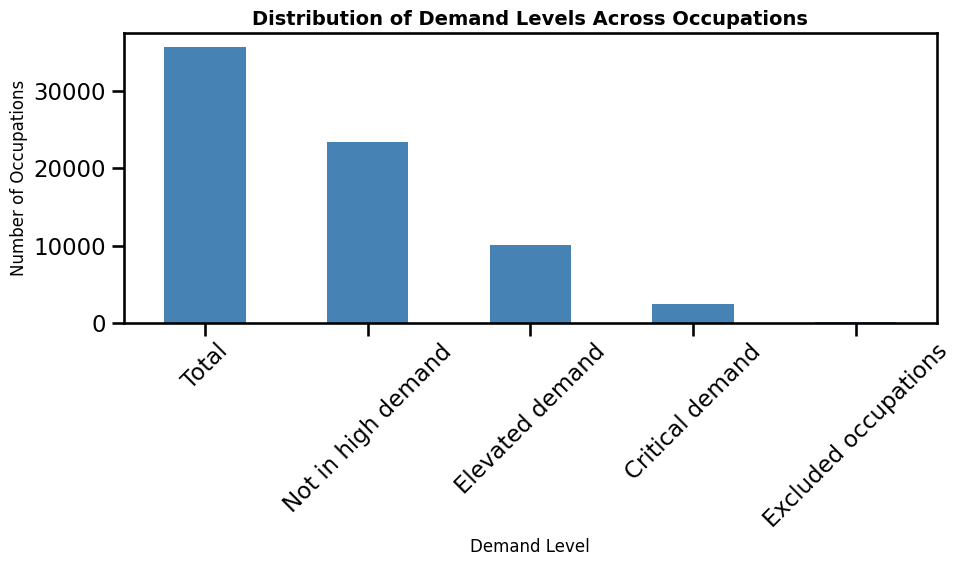

,count
demand_level,
Total,35754
Not in high demand,23431
Elevated demand,10080
Critical demand,2470
Excluded occupations,128


In [11]:
def analyze_demand_distribution(df):
    """Analyze distribution of demand levels"""
    print("\n=== DEMAND LEVEL DISTRIBUTION ===")

    if 'demand_level' not in df.columns:
        print("Demand level column not found")
        return None

    demand_dist = df['demand_level'].value_counts()
    print(demand_dist)

    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    demand_dist.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Distribution of Demand Levels Across Occupations', fontsize=14, fontweight='bold')
    ax.set_xlabel('Demand Level', fontsize=12)
    ax.set_ylabel('Number of Occupations', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    # plt.savefig('demand_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

    return demand_dist

analyze_demand_distribution(df)


=== WAGE ANALYSIS ===

Wage statistics:
Mean hourly wage: £17.12
Median hourly wage: £15.11
Min hourly wage: £10.42
Max hourly wage: £41.98
Std deviation: £5.81

Average wage by demand level:
demand_level
Critical demand         22.864869
Elevated demand         18.391307
Total                   17.110778
Excluded occupations    16.071908
Not in high demand      15.848700
Name: hourly_wage, dtype: float64


/tmp/ipython-input-1074966885.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wage_by_demand = df.groupby('demand_level')['hourly_wage'].mean().sort_values(ascending=False)


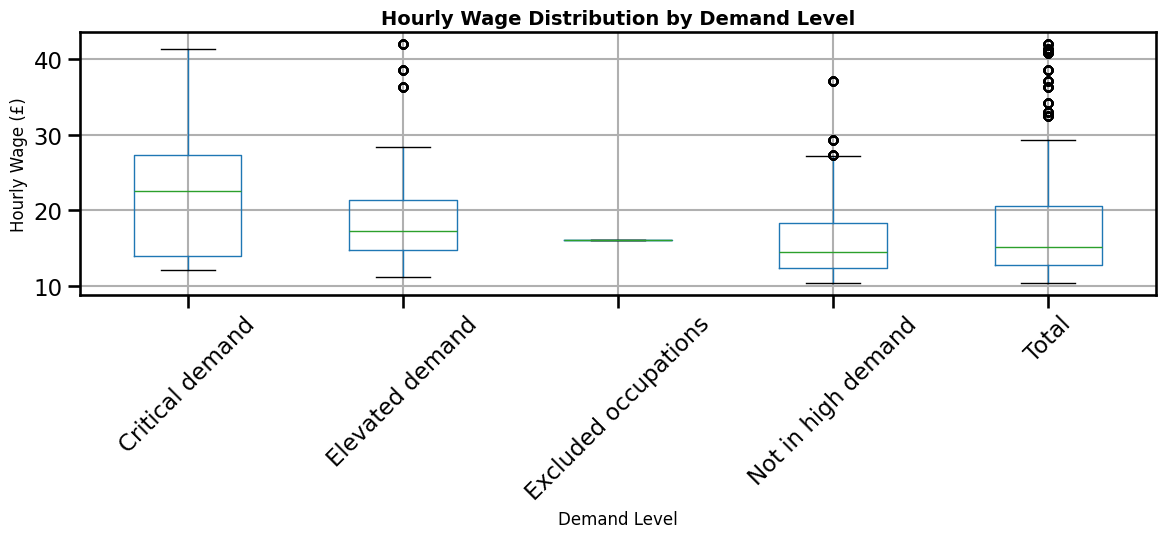

,hourly_wage
0,17.651662
1,41.980000
3,24.950000
4,23.680000
5,24.070000
...,...
71858,10.420000
71859,10.500000
71860,10.500000
71861,10.900000


In [12]:
def analyze_wages(df):
    """Analyze wage distribution"""
    print("\n=== WAGE ANALYSIS ===")

    if 'hourly_wage' not in df.columns:
        print("Wage column not found")
        return None

    wage_data = df['hourly_wage'].dropna()

    print(f"\nWage statistics:")
    print(f"Mean hourly wage: £{wage_data.mean():.2f}")
    print(f"Median hourly wage: £{wage_data.median():.2f}")
    print(f"Min hourly wage: £{wage_data.min():.2f}")
    print(f"Max hourly wage: £{wage_data.max():.2f}")
    print(f"Std deviation: £{wage_data.std():.2f}")

    # Wage by demand level
    if 'demand_level' in df.columns:
        print("\nAverage wage by demand level:")
        wage_by_demand = df.groupby('demand_level')['hourly_wage'].mean().sort_values(ascending=False)
        print(wage_by_demand)

        # Create box plot
        fig, ax = plt.subplots(figsize=(12, 6))
        df.boxplot(column='hourly_wage', by='demand_level', ax=ax)
        ax.set_title('Hourly Wage Distribution by Demand Level', fontsize=14, fontweight='bold')
        ax.set_xlabel('Demand Level', fontsize=12)
        ax.set_ylabel('Hourly Wage (£)', fontsize=12)
        plt.suptitle('')  # Remove default title
        plt.xticks(rotation=45)
        plt.tight_layout()
        # plt.savefig('wage_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()

    return wage_data

analyze_wages(df)

In [13]:
# Get value counts sorted by frequency (descending)
soc20_counts = df["soc20_label"].value_counts(dropna=False)

# Display total unique and top entries
print(f"Total unique SOC-20 labels: {soc20_counts.shape[0]}")
print("\nSOC-20 labels sorted by frequency (top 50 shown):")
print(soc20_counts.head(50))

Total unique SOC-20 labels: 370

SOC-20 labels sorted by frequency (top 50 shown):
soc20_label
Total                                                               24631
Precision instrument makers and repairers                             128
Pre-press technicians                                                 128
Postal workers, mail sorters and messengers                           128
Police officers (sergeant and below)                                  128
Police community support officers                                     128
Podiatrists                                                           128
Plumbers and heating and ventilating installers and repairers         128
Playworkers                                                           128
Plastics process operatives                                           128
Plasterers                                                            128
Planning, process and production technicians                          128
Management consul

In [14]:
def analyze_top_occupations(df, n=20):
    """Analyze top occupations by various metrics, ignoring 'Total' and duplicates."""

    # Filter out aggregate rows
    df_filtered = df[
        (df['soc20_label'] != 'Total') &
        (df['demand_level'] != 'Total') &
        (df['soc20_label'] != 'Excluded occupations')
    ].copy()

    # Convert numeric columns
    df_filtered['workers'] = pd.to_numeric(df_filtered['workers'], errors='coerce')
    df_filtered['hourly_wage'] = pd.to_numeric(df_filtered['hourly_wage'], errors='coerce')

    print(f"\n=== TOP {n} OCCUPATIONS (Filtered & Unique) ===")

    results = {}

    # --- Top by workers ---
    if 'workers' in df_filtered.columns and 'soc20_label' in df_filtered.columns:
        print(f"\nTop {n} by number of workers:")
        top_workers = (
            df_filtered.drop_duplicates(subset=['soc20_label'])
                       .nlargest(n, 'workers')[['soc20_label', 'workers', 'demand_level']]
        )
        print(top_workers.to_string(index=False))
        results['workers'] = top_workers

    # --- Top by wage ---
    if 'hourly_wage' in df_filtered.columns and 'soc20_label' in df_filtered.columns:
        print(f"\nTop {n} by hourly wage:")
        top_wage = (
            df_filtered.drop_duplicates(subset=['soc20_label'])
                       .nlargest(n, 'hourly_wage')[['soc20_label', 'hourly_wage', 'demand_level']]
        )
        print(top_wage.to_string(index=False))
        results['wage'] = top_wage

    # --- Top critical demand by workers ---
    if 'demand_level' in df_filtered.columns and 'workers' in df_filtered.columns:
        critical = df_filtered[df_filtered['demand_level'] == 'Critical demand']
        if len(critical) > 0:
            print(f"\nTop {min(n, len(critical))} critical demand occupations by workers:")
            top_critical = (
                critical.drop_duplicates(subset=['soc20_label'])
                        .nlargest(min(n, len(critical)), 'workers')[['soc20_label', 'workers', 'hourly_wage']]
            )
            print(top_critical.to_string(index=False))
            results['critical'] = top_critical

    return results

# Run analysis
analyze_top_occupations(df, n=20)



=== TOP 20 OCCUPATIONS (Filtered & Unique) ===

Top 20 by number of workers:
                                            soc20_label  workers       demand_level
                            Sales and retail assistants   930900 Not in high demand
                           Care workers and home carers   815600    Elevated demand
     Programmers and software development professionals   560900    Critical demand
                                 Cleaners and domestics   494600 Not in high demand
             Secondary education teaching professionals   443600 Not in high demand
        Book-keepers, payroll managers and wages clerks   417700    Elevated demand
                       Financial managers and directors   411400    Critical demand
                 Other registered nursing professionals   398500    Elevated demand
                        Kitchen and catering assistants   391700 Not in high demand
               Primary education teaching professionals   366900 Not in high deman

{'workers':                                             soc20_label  workers  \
 5120                        Sales and retail assistants   930900   
 4861                       Care workers and home carers   815600   
 5085  Programmers and software development professio...   560900   
 4877                             Cleaners and domestics   494600   
 5125         Secondary education teaching professionals   443600   
 4848    Book-keepers, payroll managers and wages clerks   417700   
 4941                   Financial managers and directors   411400   
 5044             Other registered nursing professionals   398500   
 4993                    Kitchen and catering assistants   391700   
 5073           Primary education teaching professionals   366900   
 5179                               Warehouse operatives   361100   
 5118   Sales accounts and business development managers   330700   
 4853  Business and financial project management prof...   317800   
 5005     Managers and 

In [15]:
def create_summary_statistics(df):
    """Create comprehensive summary statistics"""
    print("\n=== SUMMARY STATISTICS ===")

    summary = {
        'Total Occupations': len(df),
        'Total Workers': df['workers'].sum() if 'workers' in df.columns else 'N/A',
        'Average Hourly Wage': f"£{df['hourly_wage'].mean():.2f}" if 'hourly_wage' in df.columns else 'N/A',
        'Median Hourly Wage': f"£{df['hourly_wage'].median():.2f}" if 'hourly_wage' in df.columns else 'N/A'
    }

    if 'demand_level' in df.columns:
        summary['Critical Demand Occupations'] = len(df[df['demand_level'] == 'Critical demand'])
        summary['Elevated Demand Occupations'] = len(df[df['demand_level'] == 'Elevated demand'])
        summary['Not in High Demand Occupations'] = len(df[df['demand_level'] == 'Not in high demand'])

    if 'STEM' in df.columns:
        summary['STEM Occupations'] = len(df[df['STEM'] == 1])

    if 'construction' in df.columns:
        summary['Construction Occupations'] = len(df[df['construction'] == 1])

    print("\nKey Metrics:")
    for key, value in summary.items():
        print(f"  {key}: {value}")

    return summary

ret = create_summary_statistics(df)


=== SUMMARY STATISTICS ===

Key Metrics:
  Total Occupations: 71863
  Total Workers: 8389708800
  Average Hourly Wage: £17.12
  Median Hourly Wage: £15.11
  Critical Demand Occupations: 2470
  Elevated Demand Occupations: 10080
  Not in High Demand Occupations: 23431
  STEM Occupations: 12186
  Construction Occupations: 5212


In [16]:
def generate_insights(df):
    """Generate key insights from the data"""
    print("\n=== KEY INSIGHTS ===")

    insights = []

    # Insight 1: Demand distribution
    if 'demand_level' in df.columns:
        critical_pct = (df['demand_level'] == 'Critical demand').sum() / len(df) * 100
        insights.append(f"1. {critical_pct:.1f}% of occupations are in critical demand")

    # Insight 2: Skill level most in demand
    if 'skill_level' in df.columns and 'demand_level' in df.columns:
        critical = df[df['demand_level'] == 'Critical demand']
        if len(critical) > 0:
            top_skill = critical['skill_level'].mode()[0]
            insights.append(f"2. Skill level {top_skill} has the most critical demand positions")

    # Insight 3: STEM in critical demand
    if 'STEM' in df.columns and 'demand_level' in df.columns:
        stem_critical = df[(df['STEM'] == 1) & (df['demand_level'] == 'Critical demand')]
        stem_critical_pct = len(stem_critical) / len(df[df['STEM'] == 1]) * 100 if len(df[df['STEM'] == 1]) > 0 else 0
        insights.append(f"3. {stem_critical_pct:.1f}% of STEM occupations are in critical demand")

    # Insight 4: Wage gap
    if 'hourly_wage' in df.columns and 'demand_level' in df.columns:
        critical_wage = df[df['demand_level'] == 'Critical demand']['hourly_wage'].mean()
        normal_wage = df[df['demand_level'] == 'Not in high demand']['hourly_wage'].mean()
        if not np.isnan(critical_wage) and not np.isnan(normal_wage):
            wage_diff = ((critical_wage - normal_wage) / normal_wage) * 100
            insights.append(f"4. Critical demand occupations pay {abs(wage_diff):.1f}% {'more' if wage_diff > 0 else 'less'} than normal demand roles")

    # Insight 5: Largest occupation groups
    if 'workers' in df.columns and 'soc20_label' in df.columns:
        largest = df.nlargest(1, 'workers')['soc20_label'].values[0]
        insights.append(f"5. '{largest}' has the largest workforce")

    for insight in insights:
        print(f"  {insight}")

    return insights

ret = generate_insights(df)


=== KEY INSIGHTS ===
  1. 3.4% of occupations are in critical demand
  2. Skill level Total has the most critical demand positions
  3. 4.0% of STEM occupations are in critical demand
  4. Critical demand occupations pay 44.3% more than normal demand roles
  5. 'Total' has the largest workforce


In [17]:
print("\n=== GENERATING CSV FILES ===")

# Filter out 'Total' rows and select required columns
df_export = df[
    (df['soc20_label'] != 'Total') &
    (df['soc20_label'] != 'Excluded occupations')
][['soc20_label', 'hourly_wage', 'workers', 'STEM', 'demand_level']].copy()

# Remove duplicates based on soc20_label
df_export = df_export.drop_duplicates(subset=['soc20_label'])

# 1. Sort by hourly wage (descending)
df_sorted_by_wage = df_export.sort_values('hourly_wage', ascending=False)
df_sorted_by_wage.to_csv(f"{BASE}/occupations_sorted_by_wage.csv", index=False)
print(f"✓ Generated: occupations_sorted_by_wage.csv ({len(df_sorted_by_wage)} rows)")

# 2. Sort by workers (descending)
df_sorted_by_workers = df_export.sort_values('workers', ascending=False)
df_sorted_by_workers.to_csv(f"{BASE}/occupations_sorted_by_workers.csv", index=False)
print(f"✓ Generated: occupations_sorted_by_workers.csv ({len(df_sorted_by_workers)} rows)")

# 3. Sort by demand level (custom order: Critical, Elevated, Not in high demand)
demand_order = {'Critical demand': 0, 'Elevated demand': 1, 'Not in high demand': 2}
df_export['demand_order'] = df_export['demand_level'].map(demand_order)
df_sorted_by_demand = df_export.sort_values('demand_order').drop('demand_order', axis=1)
df_sorted_by_demand.to_csv(f"{BASE}/occupations_sorted_by_demand.csv", index=False)
print(f"✓ Generated: occupations_sorted_by_demand.csv ({len(df_sorted_by_demand)} rows)")

print("\nAll CSV files generated successfully!")
print(f"Location: {BASE}/")
print("\nPreview of first 5 rows from each file:")
print("\n--- Sorted by Wage ---")
print(df_sorted_by_wage.head().to_string(index=False))
print("\n--- Sorted by Workers ---")
print(df_sorted_by_workers.head().to_string(index=False))
print("\n--- Sorted by Demand ---")
print(df_sorted_by_demand.head().to_string(index=False))


=== GENERATING CSV FILES ===
✓ Generated: occupations_sorted_by_wage.csv (368 rows)
✓ Generated: occupations_sorted_by_workers.csv (368 rows)
✓ Generated: occupations_sorted_by_demand.csv (368 rows)

All CSV files generated successfully!
Location: /content/

Preview of first 5 rows from each file:

--- Sorted by Wage ---
                                  soc20_label  hourly_wage  workers  STEM demand_level
        Chief executives and senior officials        41.98   116100    -1        Total
Public relations and communications directors        41.35    41100    -1        Total
             Information technology directors        41.04   138700    -1        Total
                 Head teachers and principals        40.87    43500    -1        Total
   Marketing, sales and advertising directors        38.52   238700    -1        Total

--- Sorted by Workers ---
                                       soc20_label  hourly_wage  workers  STEM demand_level
                       Sales and re